In [35]:
#install and download needed packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import random
#Set random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # for multi-GPU setups

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import os

os.environ['PYTHONHASHSEED'] = '42'

In [36]:
data= pd.read_csv('lowa.csv')

In [37]:
data.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-33179700135,04/01/2021,2576,Hy-Vee Wine and Spirits / Storm Lake,1250 N Lake St,Storm Lake,50588.0,POINT (-95.200758 42.65318400000001),11.0,BUENA VIST,...,64870.0,Fireball Cinnamon Whiskey,48.0,100.0,0.90,1.35,48.0,64.80,4.8,1.26
1,INV-33196200106,04/01/2021,2649,Hy-Vee #3 / Dubuque,400 Locust St,Dubuque,52001.0,POINT (-90.666497 42.49721900000001),31.0,DUBUQUE,...,65200.0,Tequila Rose Liqueur,12.0,750.0,11.50,17.25,4.0,69.00,3.0,0.79
2,INV-33184300011,04/01/2021,2539,Hy-Vee Food Store / Iowa Falls,640 S. Oak,Iowa Falls,50126.0,POINT (-93.262364 42.508752),42.0,HARDIN,...,38008.0,Smirnoff 80prf PET,6.0,1750.0,14.75,22.13,6.0,132.78,10.5,2.77
3,INV-33184100015,04/01/2021,4024,Wal-Mart 1546 / Iowa Falls,840 S Oak,Iowa Falls,50126.0,POINT (-93.262446 42.503407),42.0,HARDIN,...,36648.0,Caliber Vodka,12.0,750.0,3.31,4.97,12.0,59.64,9.0,2.37
4,INV-33174200025,04/01/2021,5385,Vine Food & Liquor,2704 Vine St.,West Des Moines,50265.0,POINT (-93.741511 41.580206),77.0,POLK,...,4626.0,Buchanan Deluxe 12YR,12.0,750.0,20.99,31.49,2.0,62.98,1.5,0.39


In [75]:
data.shape

(233571, 17)

In [38]:
data=data.drop(columns=['invoice_and_item_number','store_number', 'store_name','address','zip_code',
                        'store_location'],axis=1)

In [39]:
data.shape

(1045230, 18)

In [40]:
data.dtypes

date                    object
city                    object
county_number          float64
county                  object
category                 int64
category_name           object
vendor_number          float64
vendor_name             object
item_number            float64
item_description        object
pack                   float64
bottle_volume_ml       float64
state_bottle_cost      float64
state_bottle_retail    float64
bottles_sold           float64
sale_dollars           float64
volume_sold_liters     float64
volume_sold_gallons    float64
dtype: object

In [41]:
# Try converting 'date' to datetime with errors='coerce' to handle invalid formats
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Identify rows with NaT values (result of failed conversion)
invalid_dates = data[data['date'].isna()]
print(invalid_dates)

        date             city  county_number    county  category  \
69756    NaT     Cedar Rapids           57.0      LINN   1081600   
69757    NaT             Ames           85.0     STORY   1031100   
69758    NaT  West Des Moines           77.0      POLK   1031100   
69759    NaT      Mt Pleasant           44.0     Henry   1031100   
69760    NaT       Bettendorf           82.0     SCOTT   1032100   
...      ...              ...            ...       ...       ...   
1025513  NaT        Winterset           61.0   MADISON   1012100   
1025514  NaT           George           60.0      LYON   1012100   
1025515  NaT  Missouri Valley           43.0  HARRISON   1082200   
1025516  NaT       Sioux City           97.0  WOODBURY   1011100   
1025517  NaT       Sioux City           97.0  WOODBURY   1012100   

             category_name  vendor_number           vendor_name  item_number  \
69756      Whiskey Liqueur          421.0  SAZERAC COMPANY  INC      64870.0   
69757      American Vod

In [42]:
# Drop rows with NaT in the 'date' column
data = data.dropna(subset=['date'])

In [43]:
# Convert 'date' column with a specific format (if known)
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d', errors='coerce')  # Adjust the format as needed

In [44]:
data.set_index('date', inplace=True)

<Axes: xlabel='date'>

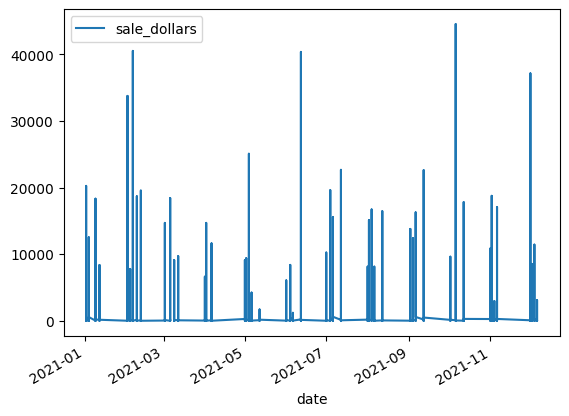

In [45]:
data.plot.line(y='sale_dollars', use_index=True)

In [46]:
data.describe()

,county_number,category,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,439874.000000,4.399110e+05,439910.000000,439910.000000,439910.000000,439910.000000,439910.000000,439910.000000,439910.000000,439910.000000,439910.000000,439910.000000
mean,57.347463,1.052406e+06,280.969155,54526.538892,12.007736,829.695217,11.216046,16.824008,11.928372,160.861629,9.469492,2.495972
std,27.583456,9.279161e+04,143.125075,91901.004268,7.920348,521.184872,12.095785,18.140979,30.270516,449.559930,36.233661,9.572150
min,1.000000,1.011100e+06,35.000000,258.000000,1.000000,20.000000,0.890000,1.340000,1.000000,1.340000,0.020000,0.000000
25%,31.000000,1.012100e+06,205.000000,27125.000000,6.000000,375.000000,6.000000,9.000000,3.000000,42.000000,1.500000,0.390000
50%,63.000000,1.031200e+06,260.000000,40053.000000,12.000000,750.000000,8.980000,13.470000,6.000000,90.000000,4.800000,1.260000
75%,77.000000,1.062500e+06,395.000000,65204.000000,12.000000,1000.000000,13.820000,20.730000,12.000000,166.500000,10.500000,2.770000
max,99.000000,1.901200e+06,978.000000,999930.000000,60.000000,5250.000000,1949.020000,2923.530000,3240.000000,44550.000000,5670.000000,1497.850000


In [47]:

#use label encoder
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in ['city','county', 'category', 'category_name','vendor_name','item_description']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

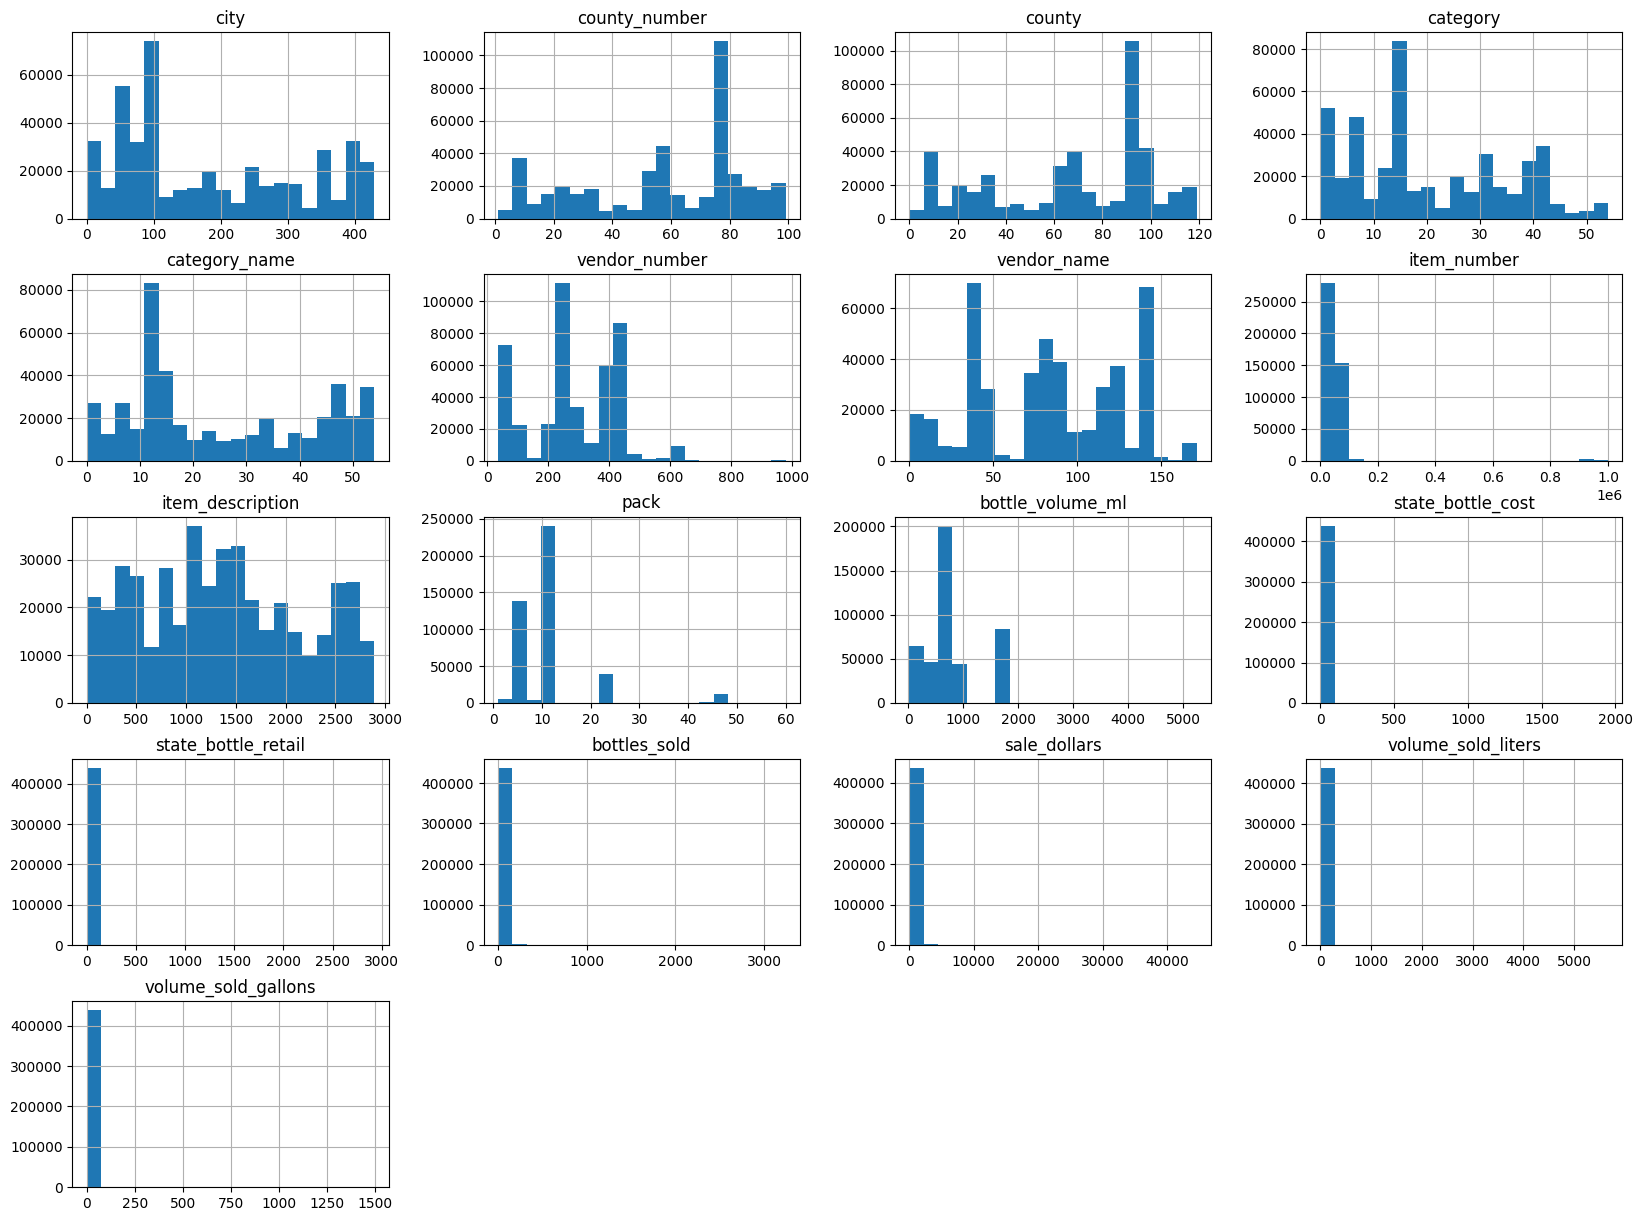

In [48]:
columns= ['city', 'county_number', 'county', 'category', 'category_name',
       'vendor_number', 'vendor_name', 'item_number', 'item_description',
       'pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons']
data[columns].hist( bins=20, figsize=(20,15));
#plt.savefig('charts_1.png')

<Axes: >

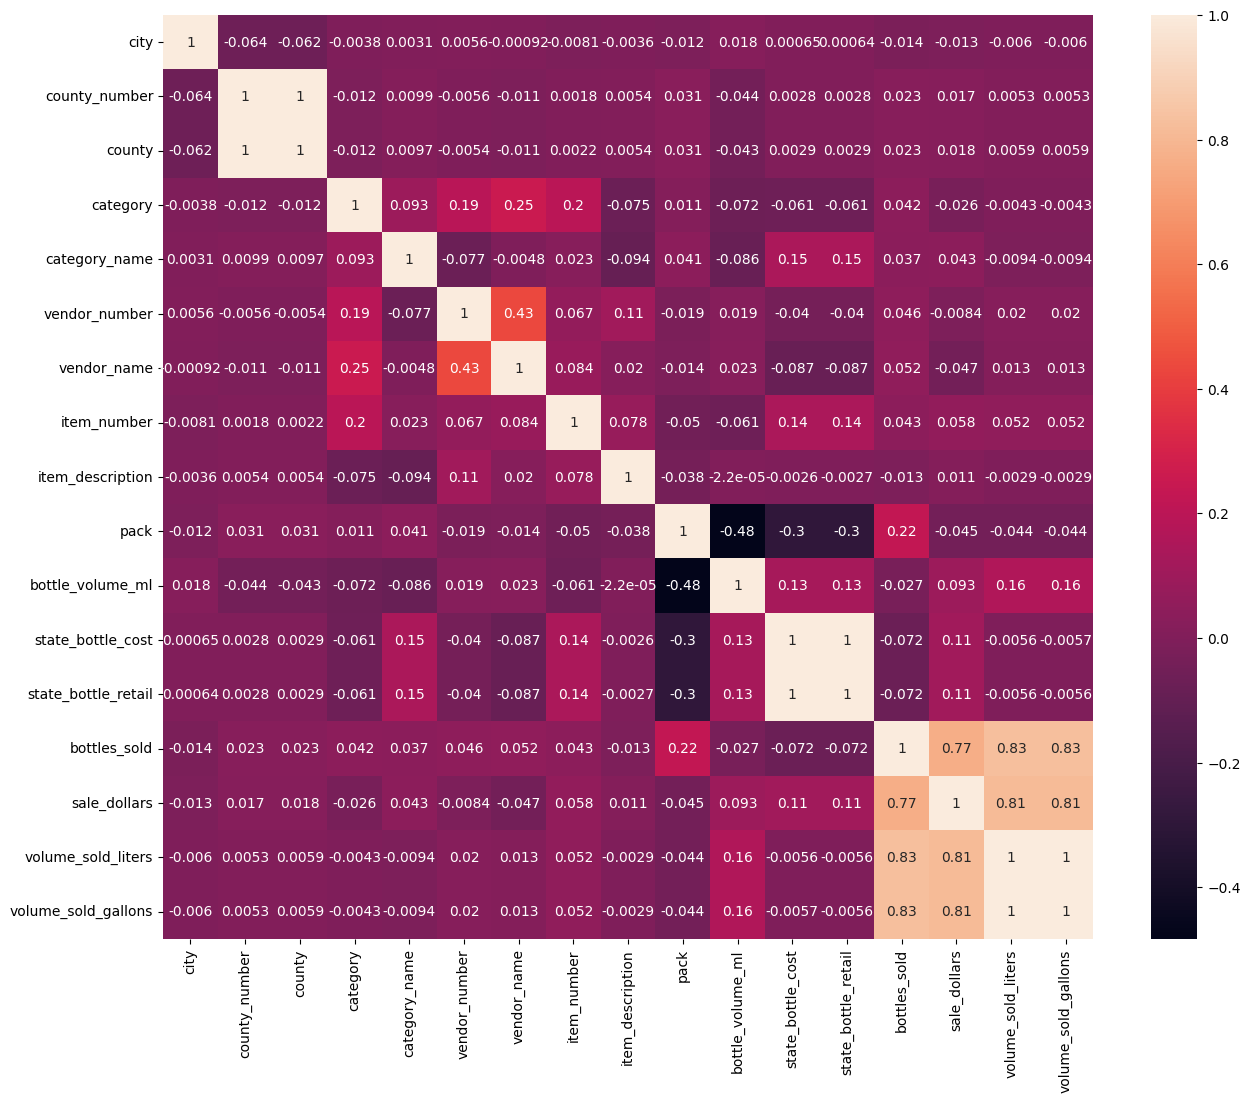

In [49]:
plt.figure(figsize=[15,12])
sns.heatmap(data.corr(), annot=True)

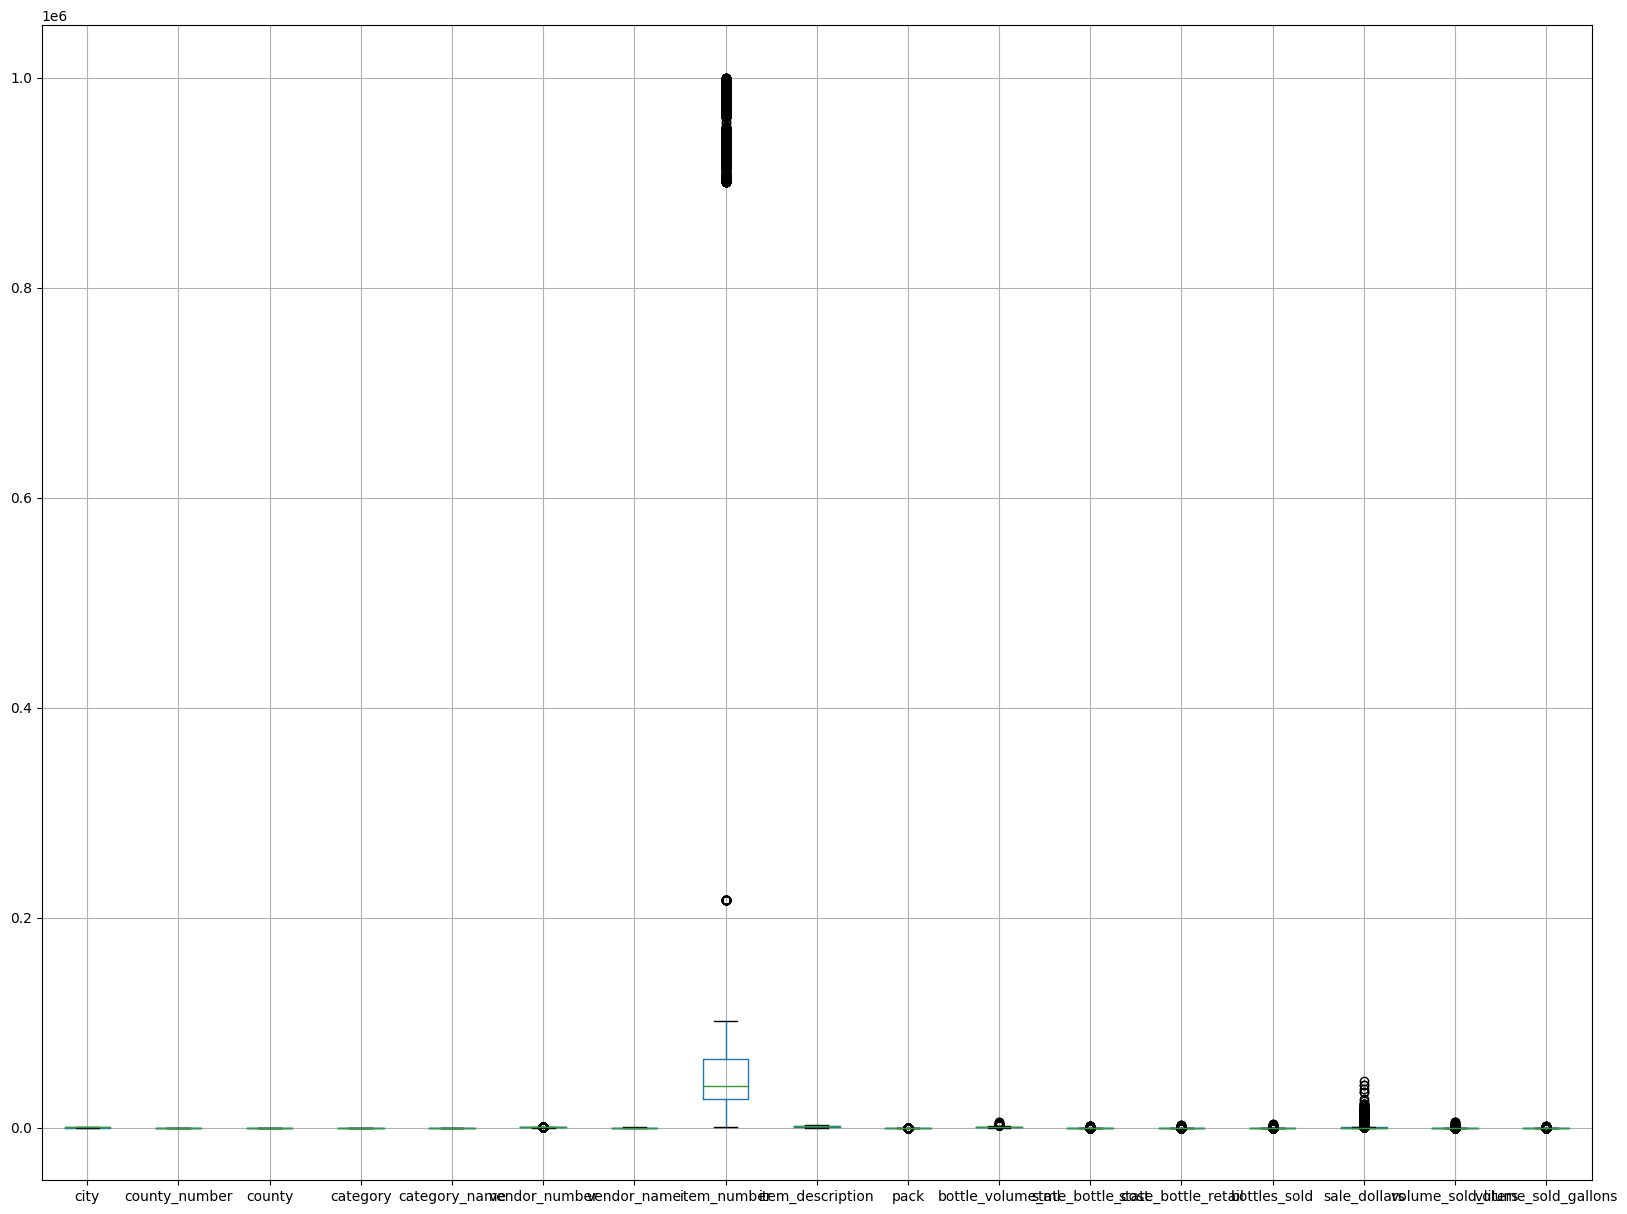

In [50]:
columns= ['city', 'county_number', 'county', 'category', 'category_name',
       'vendor_number', 'vendor_name', 'item_number', 'item_description',
       'pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail',
       'bottles_sold', 'sale_dollars', 'volume_sold_liters',
       'volume_sold_gallons']
data[columns].boxplot(  figsize=(20,15));
#plt.savefig('charts_2.png')

In [51]:
data=data.dropna()

In [52]:
data=data.drop_duplicates()

## Feature Engineering

In [53]:
x = data.drop(columns=['sale_dollars'],axis=1)
y = data['sale_dollars']

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=40)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (186856, 16)
x_test shape: (46715, 16)
y_train shape: (186856,)
y_test shape: (46715,)


In [55]:
sales_data=data

### Feature selection using the "Variance Inflation Factor (VIF)" method

In [56]:
# Utility function to return the VIF value for each feature provided
#from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(x, sales_data):
    """
    Returns a DataFrame containing features and their corresponding variance inflation factor
    features: list of features whoes multicollinearity check is needed
    df: DataFrame of the data under review
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    import pandas as pd
    X = sales_data[x]
    X['intercept'] = 1
    # Create dataframe to store vif values
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['Vif Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Feature']!='intercept'].sort_values('Vif Factor', ascending=False)
    return vif


def select_features(train_df, threshold):

    """Returns two objects;
    1. a DataFrame containing features and their corresponding variance inflation factor, and
    2. Pandas Index object containing the list of features that have the least Multicollinearity in accordance with
        the supplied threshold.
    train_df: The training dataset whoes Multicollinearity is to be checked
    threshold: value to compare VIF value with, above which, the feature droped
    """
    data = train_df.copy()
    flag = True
    while flag:
        features_to_consider = data.columns
        # Calling the "compute_vif" utility function the Variance Inflation Factor dataframe
        sorted_vif_df = (compute_vif(features_to_consider, data).reset_index().drop('index', axis=1))

        # Get the highest vif value to compare against a threshold
        highest_vif = sorted_vif_df.at[0, 'Vif Factor']

        # Compare the highest_vif with a threshold (5 was decided for this problem by the team)
        if highest_vif > threshold: # or highest_vif=='inf':
            # Select the feature corresponding to the highest_vif (index 0 for both)
            feature = sorted_vif_df.at[0, 'Feature']
            # Drop the feature
            data.drop(feature, axis=1, inplace=True)

        else:
            flag = False
    return sorted_vif_df, data.columns

In [57]:

threshold = 5
vif_df, features = select_features(x_train, threshold)

In [58]:
display(vif_df)
print(features)

,Feature,Vif Factor
0,pack,1.416573
1,bottle_volume_ml,1.310600
2,vendor_name,1.240699
3,vendor_number,1.231814
4,state_bottle_cost,1.175145
5,category,1.114363
6,item_number,1.088069
7,category_name,1.046973
8,item_description,1.033500
9,bottles_sold,1.030112


Index(['city', 'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'bottles_sold'],
      dtype='object')


In [59]:
# make a dataframe of the selected features
X_train = x_train[features]
X_train.head()

,city,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,bottles_sold
date,,,,,,,,,,,,
2021-05-01,189,60,10,36,395.0,120,15830.0,2113,12.0,750.0,14.00,12.0
2021-04-06,102,90,5,47,287.0,22,27060.0,1754,6.0,750.0,23.09,2.0
2021-08-02,57,66,1,46,260.0,38,17087.0,448,12.0,1000.0,20.49,4.0
2021-03-06,102,90,0,13,260.0,38,25608.0,2430,6.0,1750.0,12.96,3.0
2021-04-01,238,57,7,15,260.0,38,10807.0,762,12.0,750.0,15.59,12.0


In [60]:
# Feature columns and target column
features = ['city', 'county', 'category', 'category_name', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'pack',
       'bottle_volume_ml', 'state_bottle_cost', 'bottles_sold',
       'volume_sold_liters']
target = 'sale_dollars'

In [61]:


# Specify features and target
features = ['city', 'county', 'category', 'category_name', 'vendor_number',
            'vendor_name', 'item_number', 'item_description', 'pack',
            'bottle_volume_ml', 'state_bottle_cost', 'bottles_sold',
            'volume_sold_liters']
target = 'sale_dollars'




In [62]:
# Feature matrix and target vector
X = data[features]
y = data[target]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [63]:
# Create sequences
def create_sequences(X, y, seq_length=10):
    X_seqs, y_seqs = [], []
    for i in range(len(X) - seq_length):
        X_seqs.append(X[i:i+seq_length])
        y_seqs.append(y[i+seq_length])
    return np.array(X_seqs), np.array(y_seqs)



In [64]:
X_seqs, y_seqs = create_sequences(X_scaled, y)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X_seqs, y_seqs, test_size=0.2, random_state=42)


## Define GRU Model

In [65]:
# Required Libraries
import torch
import torch.nn as nn

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out




In [66]:
# Model parameters
input_size = x_train.shape[2]
hidden_size = 64
num_layers = 2
dropout_rate = 0.2
output_size = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUModel(input_size, hidden_size, num_layers, dropout_rate, output_size).to(device)

### Time to perform GRU Model Training

In [67]:
# Required Libraries
import torch.optim as optim

# Training parameters
num_epochs = 50
learning_rate = 0.001
batch_size = 32

In [68]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [69]:
g = torch.Generator()
g.manual_seed(42)

# DataLoader
train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)),
    batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)

In [70]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [71]:
# Training loop
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        outputs = outputs.squeeze()
        y_batch = y_batch.squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


Epoch 1/50, Loss: 317491.0595
Epoch 2/50, Loss: 311754.9526
Epoch 3/50, Loss: 311734.1654
Epoch 4/50, Loss: 311641.0664
Epoch 5/50, Loss: 311494.6649
Epoch 6/50, Loss: 311356.6837
Epoch 7/50, Loss: 311113.7502
Epoch 8/50, Loss: 310735.6821
Epoch 9/50, Loss: 310246.9554
Epoch 10/50, Loss: 309493.7138
Epoch 11/50, Loss: 308523.7154
Epoch 12/50, Loss: 307287.4826
Epoch 13/50, Loss: 305988.9286
Epoch 14/50, Loss: 304452.9911
Epoch 15/50, Loss: 302905.8296
Epoch 16/50, Loss: 301101.9474
Epoch 17/50, Loss: 299544.1394
Epoch 18/50, Loss: 297857.9335
Epoch 19/50, Loss: 295891.6459
Epoch 20/50, Loss: 294237.7665
Epoch 21/50, Loss: 292580.3124
Epoch 22/50, Loss: 290846.9306
Epoch 23/50, Loss: 289582.4787
Epoch 24/50, Loss: 287869.2370
Epoch 25/50, Loss: 286142.5842
Epoch 26/50, Loss: 283826.8296
Epoch 27/50, Loss: 282432.3046
Epoch 28/50, Loss: 281359.3070
Epoch 29/50, Loss: 278657.9047
Epoch 30/50, Loss: 276955.5954
Epoch 31/50, Loss: 276922.9807
Epoch 32/50, Loss: 273509.9737
Epoch 33/50, Loss

### Evaluating The Model

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluation
model.eval()
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred = model(x_test_tensor).cpu().numpy().squeeze()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')


RMSE: 579.2217
MAE: 167.5150
R^2 Score: -0.0266


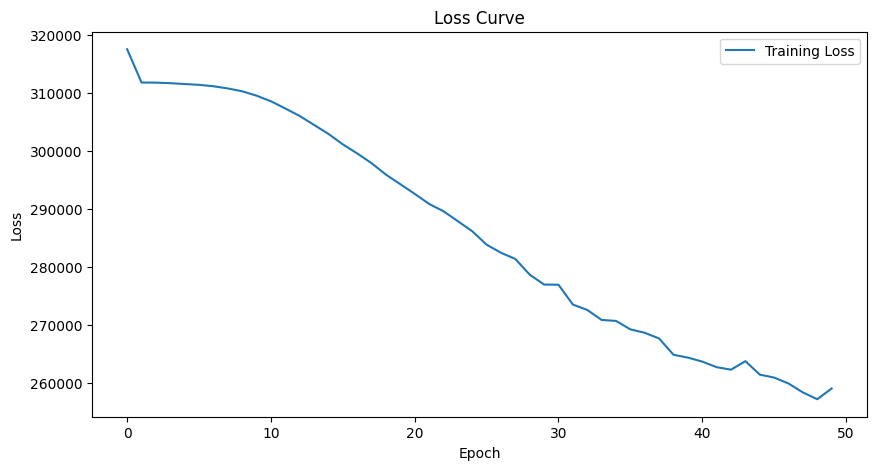

In [73]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig('grulosscurvereal.png')
plt.show()




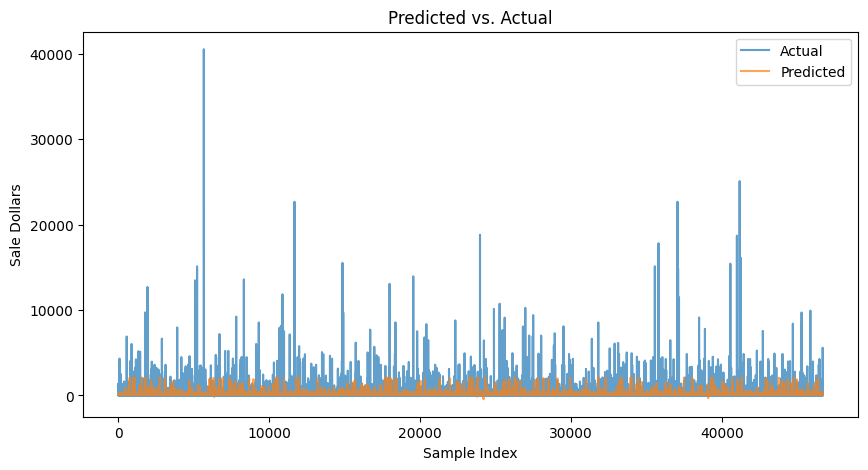

In [74]:
# Plot Predicted vs. Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Sale Dollars')
plt.title('Predicted vs. Actual')
plt.legend()
plt.savefig('grurealpred.png')
plt.show()